In [76]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pymzml

from bokeh.io import output_notebook
output_notebook();

pd.options.plotting.backend = "ms_matplotlib"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loading BokehJS ...

# Download the data

You can download the mzML file from the [Human Metabolome Database (ID: HMDB0000660)](https://hmdb.ca/spectra/ms_ms/902)

This entry contains an annotated spectrum:

| mz   | formula | SMILES    |
|------|---------|-----------|
| 45.0 | CHO2    | C(=O)O    |
| 61.0 | C2H5O2  | CC(=O)O   |
| 73.0 | C2HO3   | O=CC(=O)O |
| 75.0 | C2H3O3  | OCC(=O)O  |
| 87.0 | C3H3O3  | O=CC(=O)CO|


To generate a prediction using [CFM-ID](https://cfmid.wishartlab.com/), you can use the SMILE or InChi key. This example used the SMILE.

SMILE: OC[C@H]1OC@(CO)C@@H[C@@H]1O \
InChi: InChI=1S/C6H12O6/c7-1-2-3(8)4(9)5(10)6(11)12-2/h2-11H,1H2/t2-,3-,4+,5-,6?/m1/s1

Alternatively, you can download the example data used in this notebook by running the code below.

In [77]:
####################
# Download example

import requests
import zipfile
import io

# URL of the ZIP file
url = "https://github.com/OpenMS/pyopenms_viz/releases/download/manuscript/d_fructose_example.zip"

# Download the ZIP file
response = requests.get(url)
response.raise_for_status()  # Check for request errors

# Unzip the content
with zipfile.ZipFile(io.BytesIO(response.content)) as zip_file:
    zip_file.extractall("d_fructose_example")  # Extract to a directory
    print("Files extracted to 'd_fructose_example'")


Files extracted to 'd_fructose_example'


## Helper Functions

We will need to define the following helper methods below to help format/extract data and generate the molecular chemical drawings.

In [78]:
import importlib
from PIL import Image, ImageOps
import rdkit.RDLogger as RDLogger
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
import cairosvg
import io
import re
from typing import Tuple, Union, List

# Utility to import RDKit modules and disable logging
def rdkit_import(*module_strs: List[str]) -> Tuple:
    """Utility function to import RDKit modules and disable RDKit logging."""
    RDLogger.DisableLog('rdApp.*')
    return tuple(importlib.import_module(mod) for mod in module_strs)

def trim_img_by_white(img: Image.Image, padding: int = 0) -> Image.Image:
    """Crops the image to remove excess white space and adds padding."""
    as_array = np.array(img)
    assert as_array.ndim == 3 and as_array.shape[2] == 3, as_array.shape
    
    # Find non-white regions
    has_content = np.sum(as_array, axis=2, dtype=np.uint32) != 255 * 3
    xs, ys = np.nonzero(has_content)

    # Crop and pad
    x_range = max(min(xs) - 5, 0), min(max(xs) + 5, as_array.shape[0])
    y_range = max(min(ys) - 5, 0), min(max(ys) + 5, as_array.shape[1])
    cropped_img = as_array[x_range[0]:x_range[1], y_range[0]:y_range[1], :3]
    
    img_cropped = Image.fromarray(cropped_img, mode='RGB')
    return ImageOps.expand(img_cropped, border=padding, fill=(255, 255, 255))

def mol_from_smiles(smiles: str, standardize: bool = False) -> Union[Chem.Mol, None]:
    """Converts a SMILES string to an RDKit molecule."""
    Chem = rdkit_import("rdkit.Chem")[0]
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol and standardize:
            mol = rdkit_standardize(mol)
        return mol
    except Exception as e:
        print(f"Error converting SMILES to Mol: {e}")
        return None

def get_mol_im(smiles: str, width: int = 400, height: int = 200) -> Image.Image:
    """Generates an image of the molecule from its SMILES string."""
    mol = mol_from_smiles(smiles)
    if mol:
        d = rdMolDraw2D.MolDraw2DSVG(width, height)
        d.DrawMolecule(mol)
        d.FinishDrawing()
        svg_buf = d.GetDrawingText()
        
        png_buf = cairosvg.svg2png(bytestring=svg_buf)
        im = Image.open(io.BytesIO(png_buf))
        return trim_img_by_white(im, padding=15)
    else:
        return None

def parse_cfm_data(file_path: str, energy_section: str) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Parses CFM data for a specific energy section."""
    with open(file_path, 'r') as file:
        lines = file.readlines()

    mz_data, annotation_data = [], []
    capture_data, capture_annotations = False, False

    # Regex patterns
    energy_pattern = re.compile(f"^{energy_section}$")
    mz_pattern = re.compile(r"^(\d+\.\d+)\s+([\d\.]+)\s+([\d\s]+)\s+\(([\d\s\.]+)\)$")
    annotation_pattern = re.compile(r"^(\d+)\s+(\d+\.\d+)\s+(\S+)(?:\s+(.+))?$")

    for line in lines:
        line = line.strip()
        if energy_pattern.match(line):
            capture_data = True
            continue

        if capture_data and (line == "" or line.startswith("energy")):
            capture_data = False
            capture_annotations = True
            continue

        if capture_data:
            match = mz_pattern.match(line)
            if match:
                mz, rel_int, frag_id, probabilities = match.groups()
                mz_data.append([float(mz), float(rel_int), frag_id.strip(), probabilities.strip()])
        
        if capture_annotations:
            match = annotation_pattern.match(line)
            if match:
                frag_id, mz, smiles, note = match.groups()
                annotation_data.append([int(frag_id), float(mz), smiles, note])

    mz_df = pd.DataFrame(mz_data, columns=['mz', 'int', 'frag_id', 'probabilities'])
    annotation_df = pd.DataFrame(annotation_data, columns=['frag_id', 'mz', 'SMILES', 'note'])

    return mz_df, annotation_df

def explode_frag_ids_probabilities(df: pd.DataFrame) -> pd.DataFrame:
    """Explodes the 'frag_id' and 'probabilities' columns into multiple rows."""
    df = df.copy()
    df['frag_id'] = df['frag_id'].str.split()
    df['probabilities'] = df['probabilities'].str.split().apply(lambda x: [float(p) for p in x])
    
    return df.explode(['frag_id', 'probabilities']).astype({'frag_id': int})

def smiles_to_formula(smiles: str) -> Union[str, None]:
    """Converts a SMILES string to a molecular formula."""
    try:
        mol = Chem.MolFromSmiles(smiles)
        return rdMolDescriptors.CalcMolFormula(mol) if mol else None
    except Exception as e:
        print(f"Error converting SMILES to formula: {e}")
        return None

def format_formula(formula: str) -> str:
    """Formats a molecular formula by replacing numbers with subscripts and handling charges."""
    if isinstance(formula, str):
        # Function to replace numbers with their subscript version
        def replace_with_subscript(match):
            return f"_{{{match.group()}}}"
        
        # Replace numbers with their subscript versions
        formatted = re.sub(r'\d+', replace_with_subscript, formula)
        
        # Replace '+' and '-' with superscript versions
        formatted = formatted.replace('+', '^+').replace('-', '^-')
    
        return formatted
    else:
        return formula

## Load data

In [79]:
# Load the known annotated SMILES and formula into a dataframe
data = {
    "mz": [45.0, 61.0, 73.0, 75.0, 87.0],
    "formula": ["CHO2", "C2H5O2", "C2HO3", "C2H3O3", "C3H3O3"],
    "SMILES": ["C(=O)O", "CC(=O)O", "O=CC(=O)O", "OCC(=O)O", "O=CC(=O)CO"]
}
ann_df = pd.DataFrame(data)
ann_df

,mz,formula,SMILES
0,45.0,CHO2,C(=O)O
1,61.0,C2H5O2,CC(=O)O
2,73.0,C2HO3,O=CC(=O)O
3,75.0,C2H3O3,OCC(=O)O
4,87.0,C3H3O3,O=CC(=O)CO


We can use pymzml to load the spectrum data from the mzML file.

In [80]:
input_file = "./d_fructose_example/d_fructose_example/D-Fructose_lc_msms.mzML"

run = pymzml.run.Reader(input_file)
# Get the first spec
spec = run.next()
# Convert to Pandas DataFrame
df = pd.DataFrame(spec.centroidedPeaks).rename(columns={0:'mz', 1:'int'})
df['rel_int'] = df['int'] / df['int'].max() * 100
df['color_peak'] = "#1b9e77"
i=1
for mz in df['mz']:
    if np.floor(mz) in ann_df['mz'].values:
        # print(f"{ann_df[['mz']].isin([mz]).values.flatten()}")
        df.loc[df.mz==mz, ['custom_annotation']] = ann_df.loc[ann_df[['mz']].isin([mz]).values.flatten(), ['formula']].values[0][0]
        # Apply the formatting function to the 'formula' column
        df.loc[df.mz==mz, ['custom_annotation']] = df.loc[df.mz==mz]['custom_annotation'].apply(format_formula)
        i+=1
df.head()

[Warning] Not index found and build_index_from_scratch is False


,mz,int,rel_int,color_peak,custom_annotation
0,41.0,22.867,22.867,#1b9e77,NaN
1,45.0,47.956,47.956,#1b9e77,CHO_{2}
2,57.0,10.720,10.720,#1b9e77,NaN
3,59.0,11.557,11.557,#1b9e77,NaN
4,61.0,39.667,39.667,#1b9e77,C_{2}H_{5}O_{2}


For CFM-ID, you need to save the predictions out to a txt file using their export option. In this case, the prediction is saved to "cfm_d_fructose_inchi_prediction.txt". The energy2 prediction corresponds to the 40V collision energy of our downloaded real spectrum. 

In [81]:
# Example usage
pred_df, annotation_df = parse_cfm_data('./d_fructose_example/d_fructose_example/cfm_prediction/cfm_d_fructose_smile_prediction.txt', 'energy2')
pred_df['rel_int'] = pred_df['int'] / pred_df['int'].max() * 100
pred_df_long = explode_frag_ids_probabilities(pred_df)
pred_df['color_peak'] = "#d95f02"
i=1
for mz in pred_df['mz']:
    if np.floor(mz) in ann_df['mz'].values:
        pred_df.loc[pred_df.mz==mz, ['custom_annotation']] = f"f{i}"
        i+=1
pred_df

,mz,int,frag_id,probabilities,rel_int,color_peak,custom_annotation
0,43.017841,21.316831,35,21.317,96.883249,#d95f02,NaN
1,45.033491,22.002597,36,22.003,100.000000,#d95f02,f1
2,61.028406,9.028684,33,9.0287,41.034630,#d95f02,f2
3,71.012756,2.684029,65 82,1.8378 0.84618,12.198691,#d95f02,NaN
4,73.028406,8.475603,20 64,5.7071 2.7685,38.520923,#d95f02,f3
5,75.044056,6.354902,19 63,3.3802 2.9747,28.882509,#d95f02,f4
6,87.044056,2.562316,30 87 88,1.1642 0.88172 0.51639,11.645514,#d95f02,f5
7,91.038971,3.748550,23 77,3.5018 0.24675,17.036852,#d95f02,NaN
8,105.054621,4.215483,59 31,3.6191 0.59634,19.159026,#d95f02,NaN


We also want to create a dataframe with the predictions for each fragment ion with their corresponding probabilities.

In [82]:
pred_ann_df = annotation_df[(annotation_df['frag_id'].isin( pred_df_long.frag_id.values.tolist()))]
# Apply the function to the SMILES column to create a new column 'formula'
pred_ann_df['formula'] = pred_ann_df['SMILES'].apply(smiles_to_formula)
pred_ann_df = pred_ann_df = pred_ann_df.loc[pred_ann_df['mz'].isin(pred_df.dropna().mz.values.tolist())]
pred_ann_df.sort_values('mz', inplace=True)
pred_ann_df = pd.merge(pred_ann_df, pred_df_long, on=["frag_id", 'mz'], how="inner")
pred_ann_df.sort_values(['mz', "probabilities"], inplace=True, ascending=[True, False])
# Apply the formatting function to the 'formula' column
pred_ann_df['formatted_formula'] = pred_ann_df['formula'].apply(format_formula)
pred_ann_df

/tmp/ipykernel_923420/941010433.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_ann_df['formula'] = pred_ann_df['SMILES'].apply(smiles_to_formula)


,frag_id,mz,SMILES,note,formula,int,probabilities,rel_int,formatted_formula
0,36,45.033491,C=C[OH2+],None,C2H5O+,22.002597,22.003,100.000000,C_{2}H_{5}O^+
1,33,61.028406,OC=C[OH2+],None,C2H5O2+,9.028684,9.0287,41.034630,C_{2}H_{5}O_{2}^+
2,20,73.028406,C=C(O)C=[OH+],None,C3H5O2+,8.475603,5.7071,38.520923,C_{3}H_{5}O_{2}^+
3,64,73.028406,OCC#C[OH2+],None,C3H5O2+,8.475603,2.7685,38.520923,C_{3}H_{5}O_{2}^+
4,19,75.044056,C=C(O)C[OH2+],None,C3H7O2+,6.354902,3.3802,28.882509,C_{3}H_{7}O_{2}^+
5,63,75.044056,OCC=C[OH2+],None,C3H7O2+,6.354902,2.9747,28.882509,C_{3}H_{7}O_{2}^+
6,30,87.044056,C#CC([OH2+])CO,None,C4H7O2+,2.562316,1.1642,11.645514,C_{4}H_{7}O_{2}^+
7,87,87.044056,OCCC#C[OH2+],None,C4H7O2+,2.562316,0.88172,11.645514,C_{4}H_{7}O_{2}^+
8,88,87.044056,CC(O)C#C[OH2+],None,C4H7O2+,2.562316,0.51639,11.645514,C_{4}H_{7}O_{2}^+


In [83]:
# Create the figure
fig = plt.figure(figsize=(19, 9), dpi=300)

# Create the gridspec layout: 1 row and 2 columns, with larger space on the left
gs = fig.add_gridspec(1, 2, width_ratios=[2.5, 2], wspace=0.05)


<Figure size 5700x2700 with 0 Axes>

In [84]:
# Create the main spectrum subplot
ax1 = fig.add_subplot(gs[0, 0])

# Plot Mass Spectrum
p = df.plot(kind="spectrum", x="mz", y="rel_int", title="D-Fructose", ylabel="Relative Intensity",
        bin_peaks=False,
             reference_spectrum=pred_df[['mz', 'rel_int', 'color_peak']].assign(custom_annotation=""), 
             mirror_spectrum=True, 
             annotate_mz=False, annotate_top_n_peaks='all',
            #  annotation_color="color_annotation", 
             custom_annotation="custom_annotation",
             peak_color="color_peak",
            annotation_font_size=16,
            xlabel_font_size=20,
            ylabel_font_size=20,
            width=1000, height=700, grid=False, fig=ax1)
ax1.set_xlim([39, 183])
ax1.set_ylim(-105, 105)
# Customize the y-axis ticks and labels
y_ticks = ax1.get_yticks()
ax1.set_yticks(y_ticks)
ax1.set_yticklabels([f'{abs(y):.0f}' for y in y_ticks])
# Update the title, xlabel, and ylabel
ax1.set_title("D-Fructose", fontsize=22)
ax1.set_xlabel("mass-to-charge", fontsize=20)
ax1.set_ylabel("Relative Intensity", fontsize=20)
# Update axis tick labels
ax1.tick_params(axis="x", labelsize=18)
ax1.tick_params(axis="y", labelsize=18)

font_size=16
leg_font_size = 0.9*font_size
leg_kws = {'ncol': 1, 'fontsize': leg_font_size, "loc": "upper left"}
handles = [
    patches.Patch(facecolor="#1b9e77",label="Real",alpha=1.0),
    patches.Patch(facecolor="#d95f02",label="Predicted",alpha=1.0),
]
leg = ax1.legend(handles=handles,**leg_kws)

mol_im = get_mol_im("OC[C@H]1O[C@](O)(CO)[C@@H](O)[C@@H]1O", 600, 500)
mol_im_arr = np.array(mol_im)
# Create an inset axes in the top right corner
axins = inset_axes(ax1, 
                   width="40%", # width = 30% of parent_bbox
                   height="40%", # height : 30%
                   loc='upper right')

# Display the molecular image in the inset
axins.imshow(mol_im_arr)
axins.axis('off')  # Turn off axis labels

(-0.5, 578.5, 362.5, -0.5)

In [85]:
## Add predicted annotations

# Sort the DataFrame by m/z values
pred_df_sorted = pred_df.sort_values('mz').dropna()

# Define your custom shifts
x_shifts = [0, 0, -6, 10, 0]  
y_shifts = [0, 0, 0, 0, 0]  

# Base offsets
base_x_offset = -7
base_y_offset = -25

for i, row in enumerate(pred_df_sorted.itertuples(index=False)):
    mz, intensity, frag_id, probabilities, y, color_peak, text = row
    
    # Get the custom shifts for this annotation
    x_shift = x_shifts[i] if i < len(x_shifts) else 0
    y_shift = y_shifts[i] if i < len(y_shifts) else 0
    
    # Calculate the final offsets
    x_offset = base_x_offset + x_shift
    y_offset = base_y_offset + y_shift
    
    # Add the annotation
    ax1.annotate(
        text,
        xy=(mz, -y),  # The point to annotate
        xytext=(x_offset, y_offset),
        textcoords="offset points",
        fontsize=17,
        color="white",
        bbox={"boxstyle": "circle", "color":"#d95f02", 'fc':"#e57f1d"},
        arrowprops=dict(facecolor='grey'),
    )

In [86]:
# Right side: use gridspec with rows based on unique m/z values and 4 columns (1 for annotation, 3 for molecules)
unique_mz = pred_ann_df['mz'].unique()
num_rows = len(unique_mz)
gs_right = gs[0, 1].subgridspec(num_rows, 4, width_ratios=[2.5, 3, 3, 3])  # Increased width for annotation column
i = 1

# Create subplots in the grid on the right
for row, mz in enumerate(unique_mz):
    mz_df = pred_ann_df[pred_ann_df['mz'] == mz]
    
    # Add annotation column
    ax_annot = fig.add_subplot(gs_right[row, 0])
    
    # Add circular f# annotation
    ax_annot.annotate(f'f{i}', xy=(0.1, 0.5), xycoords='axes fraction',
                      fontsize=17, color="white",
                      bbox={"boxstyle": "circle", "color":"#d95f02", 'fc':"#e57f1d"})
    
    # Add formula annotation
    ax_annot.text(0.5, 0.5, r'${}$'.format(mz_df.iloc[0]["formatted_formula"]), 
                  ha='left', va='center', fontsize=20)
    
    ax_annot.axis('off')
    
    # Add molecule images
    for col, (idx, row_data) in enumerate(mz_df.iterrows()):
        if col < 3:  # Limit to 3 columns
            ax = fig.add_subplot(gs_right[row, col+1])
            mol_im = get_mol_im(row_data['SMILES'], 200, 100)
            mol_im_arr = np.array(mol_im)
            ax.imshow(mol_im_arr)
            
            # Add probability text below the molecule
            prob = row_data['probabilities']
            ax.text(0.5, -0.1, f"Score: {prob:.4f}", transform=ax.transAxes, 
                    ha='center', va='top', fontsize=18)
            
            ax.axis('off')
    i += 1

/tmp/ipykernel_923420/156691438.py:1: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


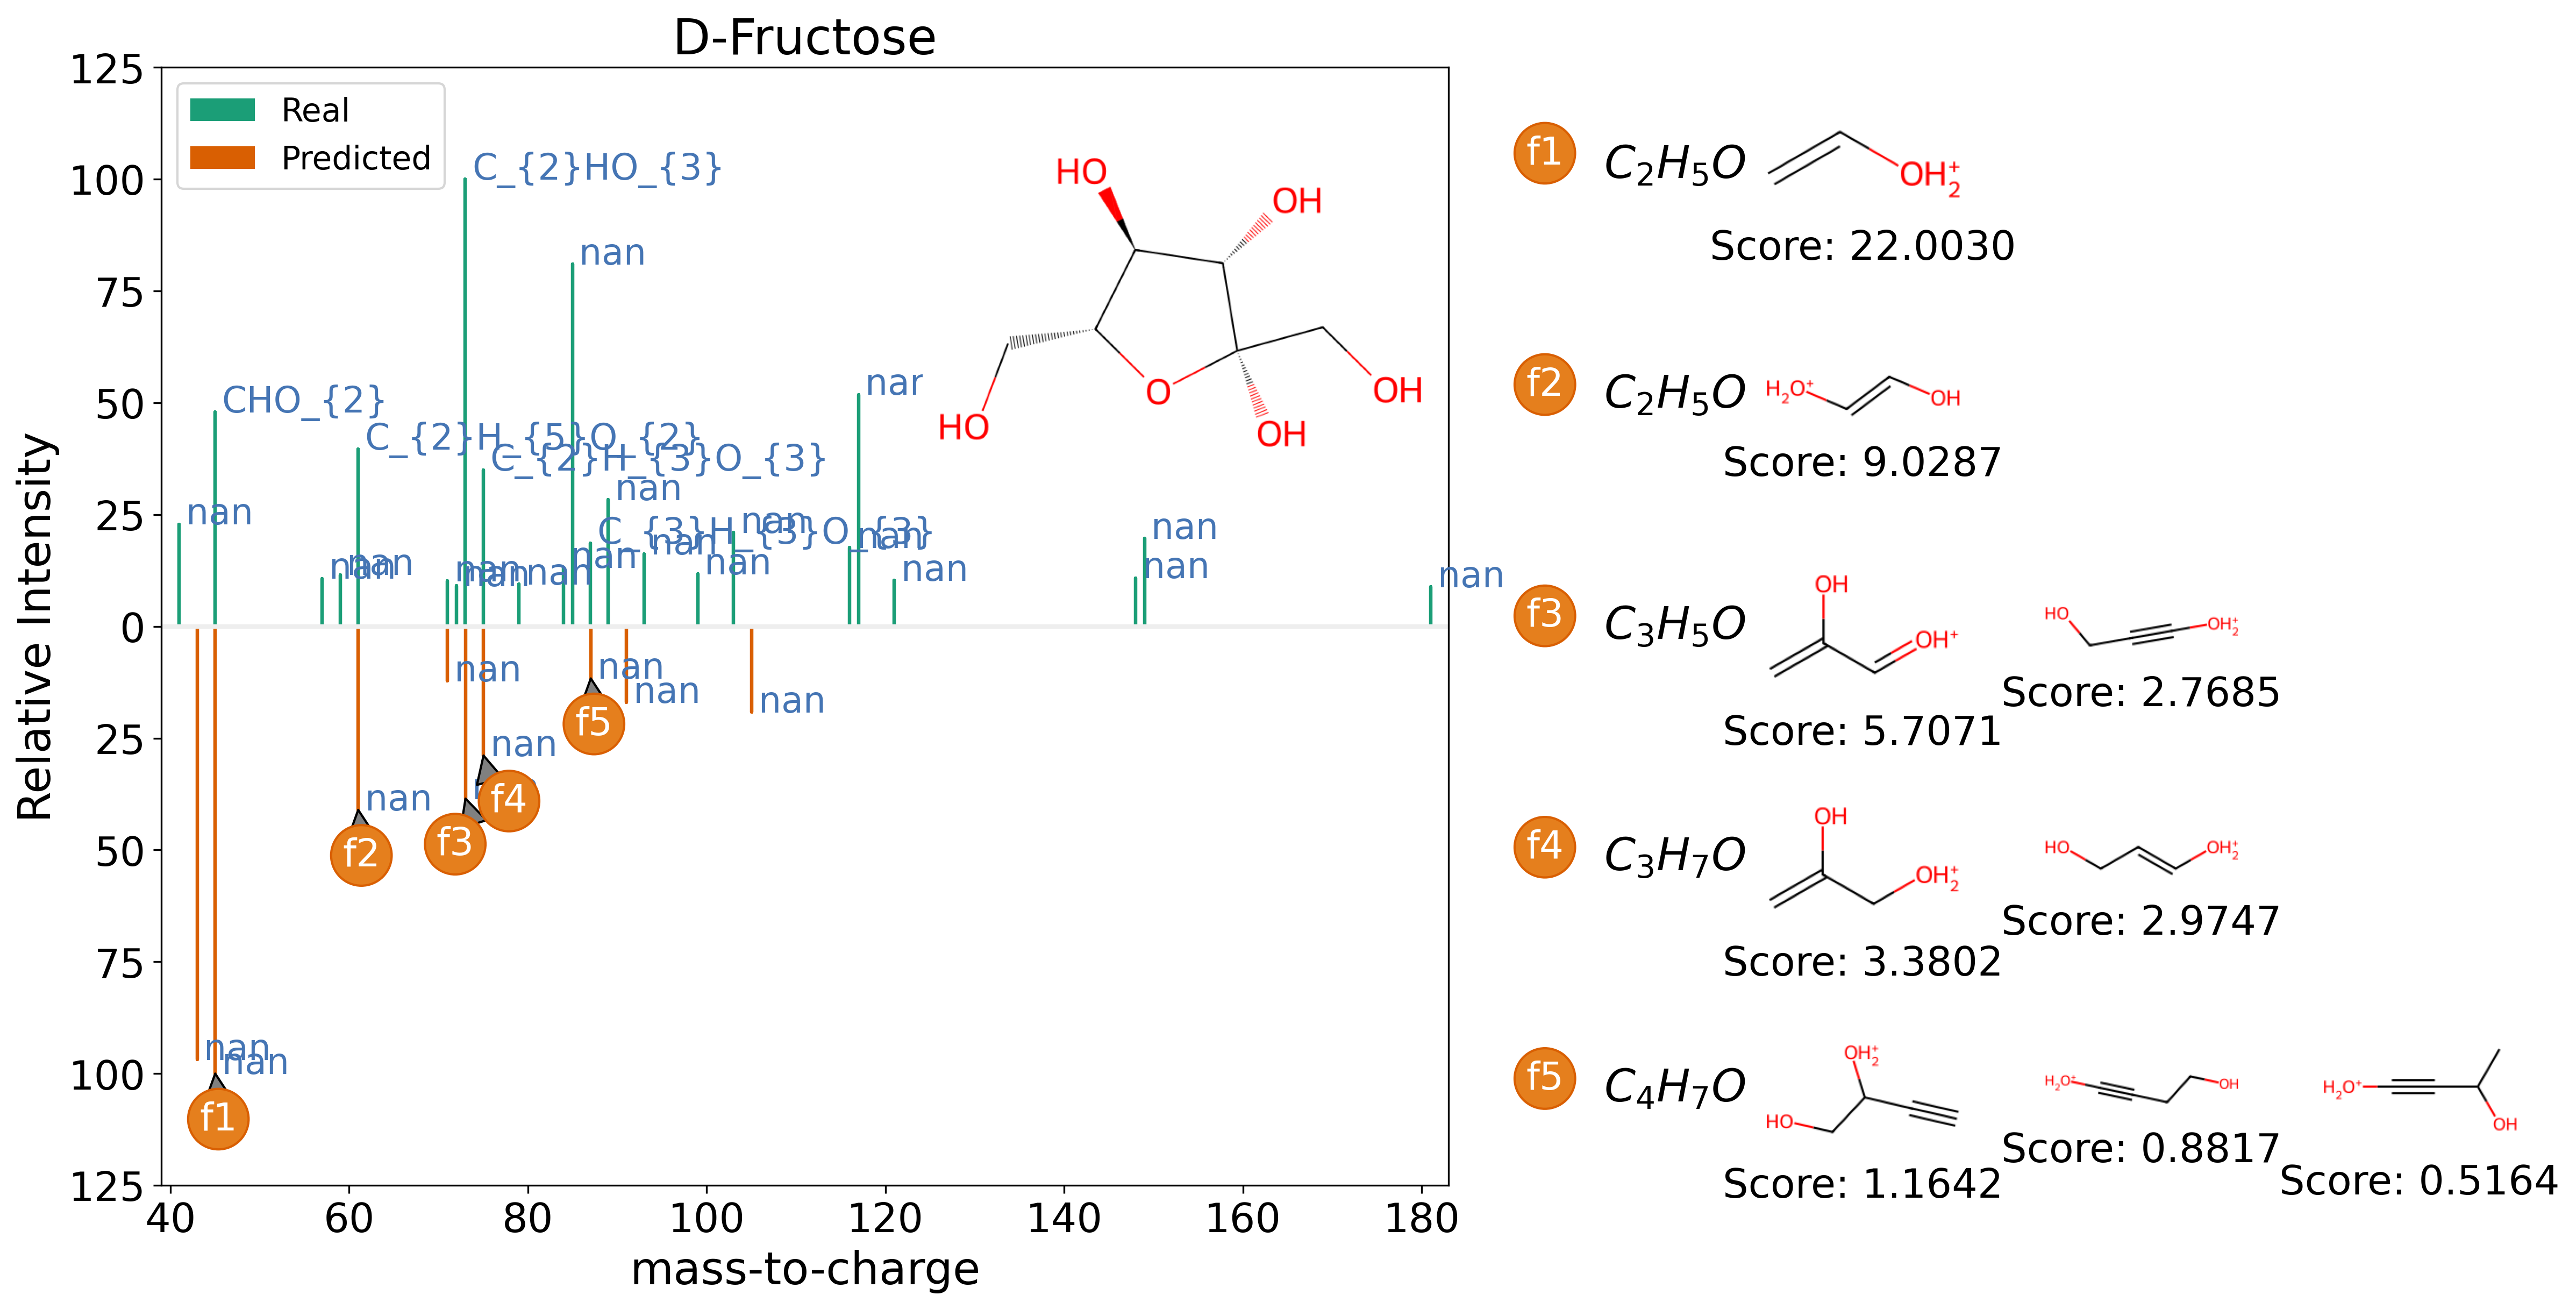

In [87]:
fig.tight_layout()
fig

In [88]:
# fig.savefig("d_fructose_prediction.png")